In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Dataset-wide Analysis of Optimal Sequence Length and SSA Components
#
# This notebook analyzes the entire structural break dataset to determine:
# 1. Optimal sequence lengths based on frequency analysis
# 2. Optimal SSA components (bottleneck dimensions) for autoencoder architectures
# 3. Distributions and statistics of these parameters across the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.linalg import svd
from scipy.sparse.linalg import svds
from sklearn.linear_model import LinearRegression
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import warnings

from src.data.data_utility import get_sliding_windows_from_sequence

warnings.filterwarnings('ignore')

# Import the data loader
from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [47]:
def determine_optimal_ssa_components(time_series: np.ndarray,
                                 max_window_length: Optional[int] = None,
                                 variance_threshold: float = 0.95,
                                 noise_threshold: float = 0.01) -> Dict:
    """
    Determine optimal number of SSA components based on singular value decomposition.
    
    Parameters
    ----------
    time_series : np.ndarray
        Input time series
    max_window_length : int, optional
        Maximum window length to consider (default: N//3)
    variance_threshold : float
        Threshold for cumulative explained variance (default: 0.95)
    noise_threshold : float
        Threshold for identifying noise components (default: 0.01)
    
    Returns
    -------
    results : Dict
        Analysis results including optimal components, explained variance, etc.
    """
    results = {}
    N = len(time_series)

    # Default window length (L should be approximately N/3 to N/2)
    max_window_length = min(N // 2, 200)

    # Test different window lengths to find optimal embedding dimension
    window_results = []

    for L in range(5, max_window_length + 1, 5):  # Test odd lengths
        # Create trajectory matrix
        trajectory_matrix = get_sliding_windows_from_sequence(time_series, L)
        U, s, Vt = svd(trajectory_matrix, full_matrices=False)

        # Calculate explained variance
        total_variance = np.sum(s ** 2)
        explained_variance_ratio = s ** 2 / total_variance
        cumulative_variance = np.cumsum(explained_variance_ratio)

        # Find components for different criteria
        n_components_95 = np.argmax(cumulative_variance >= variance_threshold) + 1

        # Advanced elbow detection using second derivative
        if len(s) > 3:
            # Log of singular values for better elbow detection
            log_s = np.log(s + 1e-10)

            # Calculate curvature (second derivative)
            if len(log_s) > 2:
                second_deriv = np.diff(log_s, 2)
                # Find the point of maximum curvature (most negative second derivative)
                elbow_idx = np.argmin(second_deriv) + 2
            else:
                elbow_idx = len(s) // 2

            # Also check for where singular values become "small"
            # Normalize singular values
            s_norm = s / s[0]
            noise_components = np.where(s_norm < noise_threshold)[0]
            if len(noise_components) > 0:
                noise_cutoff = noise_components[0]
            else:
                noise_cutoff = len(s)

            # Choose the more conservative estimate
            n_components_elbow = min(elbow_idx, noise_cutoff)
        else:
            n_components_elbow = min(3, len(s))

        # Calculate reconstruction quality
        reconstruction_error = 1 - cumulative_variance[min(n_components_elbow - 1, len(cumulative_variance) - 1)]

        # Store results for this window length
        window_results.append({
            'window_length': L,
            'n_components_95': n_components_95,
            'n_components_elbow': n_components_elbow,
            'reconstruction_error': reconstruction_error,
            'singular_values': s[:10],  # Store first 10 for analysis
            'explained_variance_ratio': explained_variance_ratio[:20],  # Store first 20
            'cumulative_variance': cumulative_variance[:20],
            'total_variance': total_variance,
            'condition_number': s[0] / s[-1] if len(s) > 1 else 1.0
        })

    if not window_results:
        results['status'] = 'analysis_failed'
        results['optimal_components'] = 5
        results['optimal_window_length'] = min(10, N // 4)
        return results

    # Select best window length based on multiple criteria
    window_df = pd.DataFrame(window_results)

    # Score each window length
    scores = []
    for _, row in window_df.iterrows():
        # Prefer window lengths with:
        # 1. Clear elbow (low reconstruction error)
        # 2. Good condition number (not too ill-conditioned)
        # 3. Reasonable number of components

        error_score = 1 - row['reconstruction_error']  # Lower error is better
        condition_score = 1 / (1 + np.log10(row['condition_number']))  # Lower condition number is better
        component_score = 1 / (1 + row['n_components_elbow'] / row['window_length'])  # Prefer fewer components relative to window

        total_score = error_score * 0.5 + condition_score * 0.3 + component_score * 0.2
        scores.append(total_score)

    # Select best window length
    best_idx = np.argmax(scores)
    best_result = window_results[best_idx]

    # Determine final optimal components
    optimal_components = min(
        best_result['n_components_elbow'],
        best_result['n_components_95']
    )

    # Apply reasonable bounds
    optimal_components = max(2, min(optimal_components, 40))

    # Store final results
    results.update({
        'status': 'success',
        'optimal_components': optimal_components,
        'optimal_window_length': best_result['window_length'],
        'n_components_95': best_result['n_components_95'],
        'n_components_elbow': best_result['n_components_elbow'],
        'reconstruction_error': best_result['reconstruction_error'],
        'singular_values': best_result['singular_values'],
        'explained_variance_ratio': best_result['explained_variance_ratio'],
        'cumulative_variance': best_result['cumulative_variance'],
        'compression_ratio': best_result['window_length'] / optimal_components,
        'window_analysis': window_results[:10],  # Store top 10 for debugging
        'condition_number': best_result['condition_number']
    })

    return results

In [48]:
# Load the data
print("Loading data...")
data_loader = StructuralBreakDataLoader()
X_train, y_train, X_test = data_loader.load_data(use_crunch=False)

# Get all time series
train_series = data_loader.get_all_train_series()
test_series = data_loader.get_all_test_series()

print(f"Loaded {len(train_series)} training series and {len(test_series)} test series")
print(f"Class distribution - Positive: {sum(ts.has_break for ts in train_series.values())}, "
      f"Negative: {sum(not ts.has_break for ts in train_series.values())}")

Loading data...


INFO:src.data.dataLoader:Data loaded successfully from local files


Loaded 10001 training series and 101 test series
Class distribution - Positive: 2909, Negative: 7092


In [49]:
# Analyze all time series
print("\nAnalyzing optimal parameters for all time series using SSA...")
print("This may take a while...\n")

# Storage for results
seq_length_results = []
ssa_results = []
analysis_metadata = []

# Process both train and test series (sample first for testing)
all_series = list(train_series.items()) + list(test_series.items())

# For testing, sample a subset
sample_size = min(100, len(all_series))  # Adjust this number as needed
sampled_series = np.random.choice(len(all_series), size=sample_size, replace=False)
print(f"Analyzing {sample_size} randomly sampled series...")

for idx in tqdm(sampled_series, desc="Processing time series"):
    series_id, ts_data = all_series[idx]

    # Get the full time series
    time_series = ts_data.values

    # 2. SSA Analysis for bottleneck dimension
    try:
        ssa_analysis = determine_optimal_ssa_components(time_series)

        ssa_results.append({
            'series_id': series_id,
            'series_length': len(time_series),
            'optimal_components': ssa_analysis['optimal_components'],
            'optimal_window_length': ssa_analysis['optimal_window_length'],
            'n_components_95': ssa_analysis.get('n_components_95', None),
            'n_components_elbow': ssa_analysis.get('n_components_elbow', None),
            'reconstruction_error': ssa_analysis.get('reconstruction_error', None),
            'compression_ratio': ssa_analysis.get('compression_ratio', None),
            'condition_number': ssa_analysis.get('condition_number', None),
            'status': ssa_analysis['status'],
            'is_train': series_id in train_series,
            'has_break': ts_data.has_break if hasattr(ts_data, 'has_break') and ts_data.has_break is not None else None
        })

        # Store detailed metadata for later analysis
        analysis_metadata.append({
            'series_id': series_id,
            'singular_values': ssa_analysis.get('singular_values', None),
            'explained_variance_ratio': ssa_analysis.get('explained_variance_ratio', None),
            'cumulative_variance': ssa_analysis.get('cumulative_variance', None),
            'window_analysis': ssa_analysis.get('window_analysis', None)
        })

    except Exception as e:
        print(f"\nError processing series {series_id}: {e}")
        continue


Analyzing optimal parameters for all time series using SSA...
This may take a while...

Analyzing 100 randomly sampled series...


Processing time series: 100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


In [50]:
# Convert results to DataFrames
seq_length_df = pd.DataFrame(seq_length_results)
ssa_df = pd.DataFrame(ssa_results)

print(f"\nAnalysis complete!")
print(f"Sequence length analysis: {len(seq_length_df)} series")
print(f"SSA analysis: {len(ssa_df)} series")


Analysis complete!
Sequence length analysis: 0 series
SSA analysis: 100 series


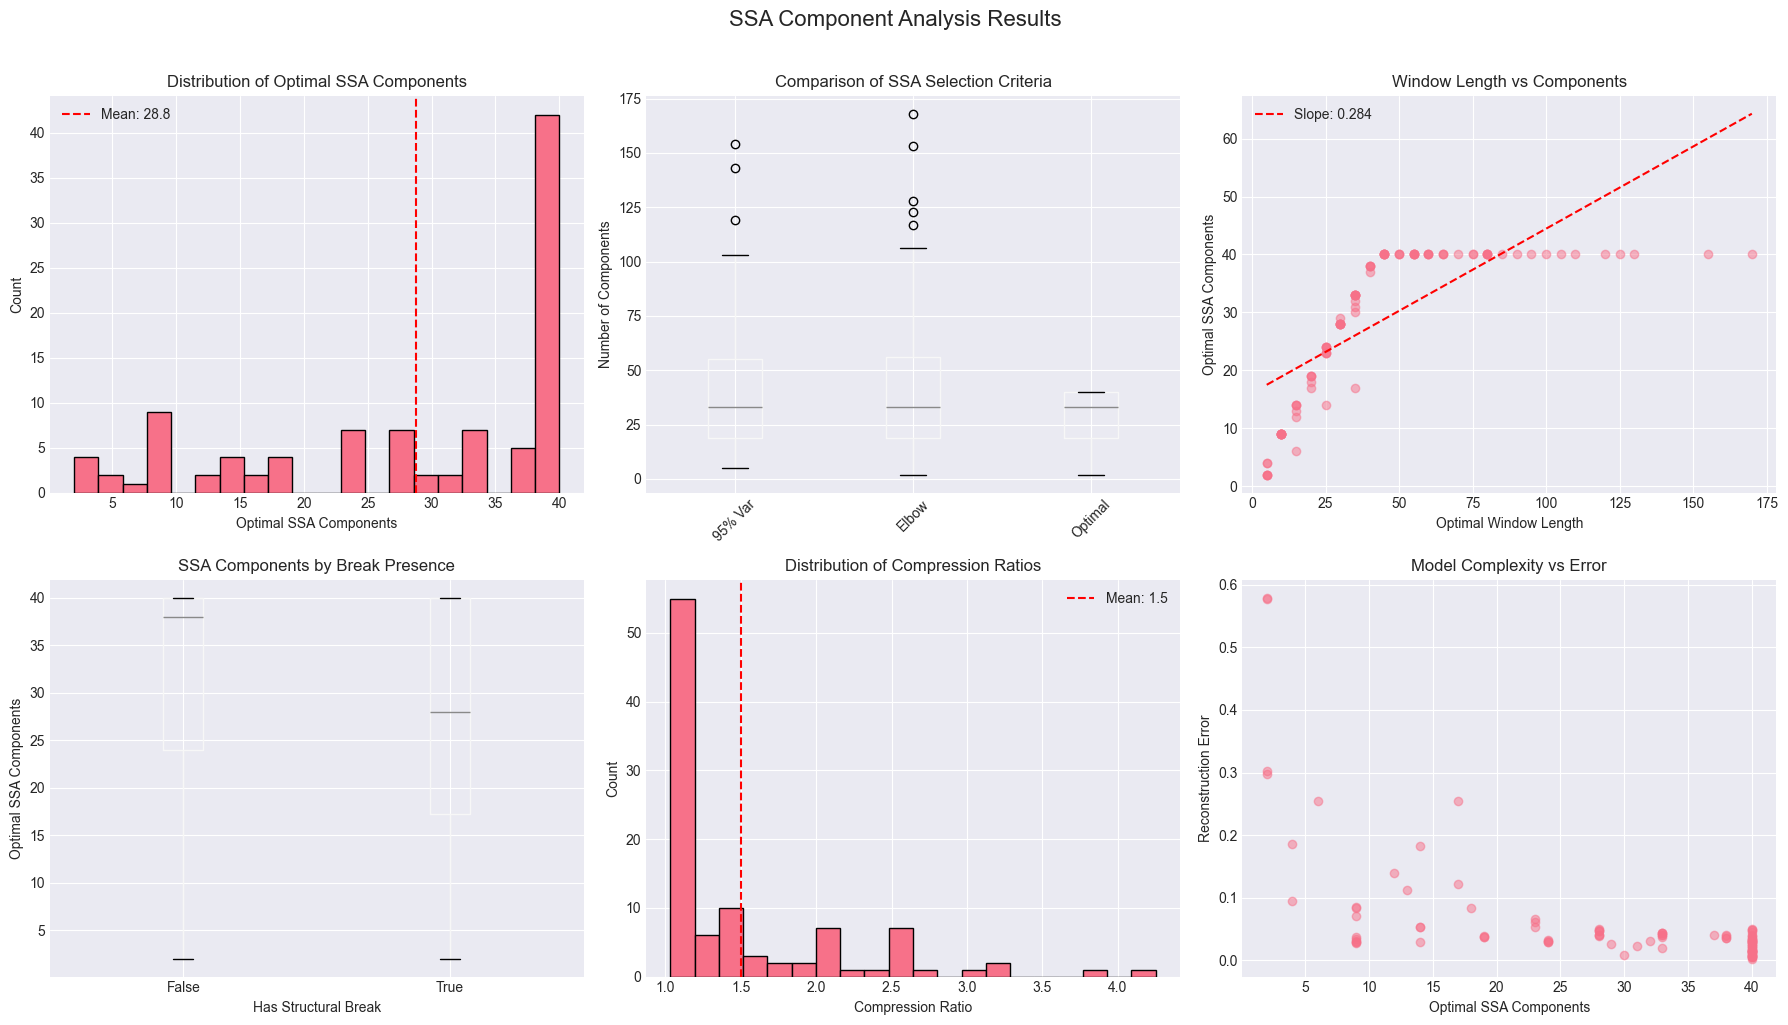

In [51]:
# Visualize SSA component distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribution of optimal components
ax = axes[0, 0]
ssa_df['optimal_components'].hist(bins=20, ax=ax, edgecolor='black')
ax.set_xlabel('Optimal SSA Components')
ax.set_ylabel('Count')
ax.set_title('Distribution of Optimal SSA Components')
ax.axvline(ssa_df['optimal_components'].mean(), color='red', linestyle='--',
           label=f'Mean: {ssa_df["optimal_components"].mean():.1f}')
ax.legend()

# 2. Comparison of different criteria
ax = axes[0, 1]
criteria_df = ssa_df[['n_components_95', 'n_components_elbow', 'optimal_components']].dropna()
if len(criteria_df) > 0:
    criteria_df.boxplot(ax=ax)
    ax.set_title('Comparison of SSA Selection Criteria')
    ax.set_ylabel('Number of Components')
    ax.set_xticklabels(['95% Var', 'Elbow', 'Optimal'], rotation=45)

# 3. Optimal window length vs optimal components
ax = axes[0, 2]
ax.scatter(ssa_df['optimal_window_length'], ssa_df['optimal_components'], alpha=0.5)
ax.set_xlabel('Optimal Window Length')
ax.set_ylabel('Optimal SSA Components')
ax.set_title('Window Length vs Components')

# Add trend line
X = ssa_df['optimal_window_length'].values.reshape(-1, 1)
y = ssa_df['optimal_components'].values
reg = LinearRegression().fit(X, y)
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = reg.predict(X_pred)
ax.plot(X_pred, y_pred, 'r--', label=f'Slope: {reg.coef_[0]:.3f}')
ax.legend()

# 4. Distribution by break presence (train only)
ax = axes[1, 0]
train_ssa = ssa_df[ssa_df['is_train'] & ssa_df['has_break'].notna()]
if len(train_ssa) > 0:
    train_ssa.boxplot(column='optimal_components', by='has_break', ax=ax)
    ax.set_title('SSA Components by Break Presence')
    ax.set_xlabel('Has Structural Break')
    ax.set_ylabel('Optimal SSA Components')

# 5. Compression ratio distribution
ax = axes[1, 1]
ssa_df['compression_ratio'].hist(bins=20, ax=ax, edgecolor='black')
ax.set_xlabel('Compression Ratio')
ax.set_ylabel('Count')
ax.set_title('Distribution of Compression Ratios')
ax.axvline(ssa_df['compression_ratio'].mean(), color='red', linestyle='--',
           label=f'Mean: {ssa_df["compression_ratio"].mean():.1f}')
ax.legend()

# 6. Reconstruction error vs components
ax = axes[1, 2]
ax.scatter(ssa_df['optimal_components'], ssa_df['reconstruction_error'], alpha=0.5)
ax.set_xlabel('Optimal SSA Components')
ax.set_ylabel('Reconstruction Error')
ax.set_title('Model Complexity vs Error')

plt.tight_layout()
plt.suptitle('SSA Component Analysis Results', y=1.02, fontsize=16)
plt.show()


=== SINGULAR VALUE ANALYSIS ===


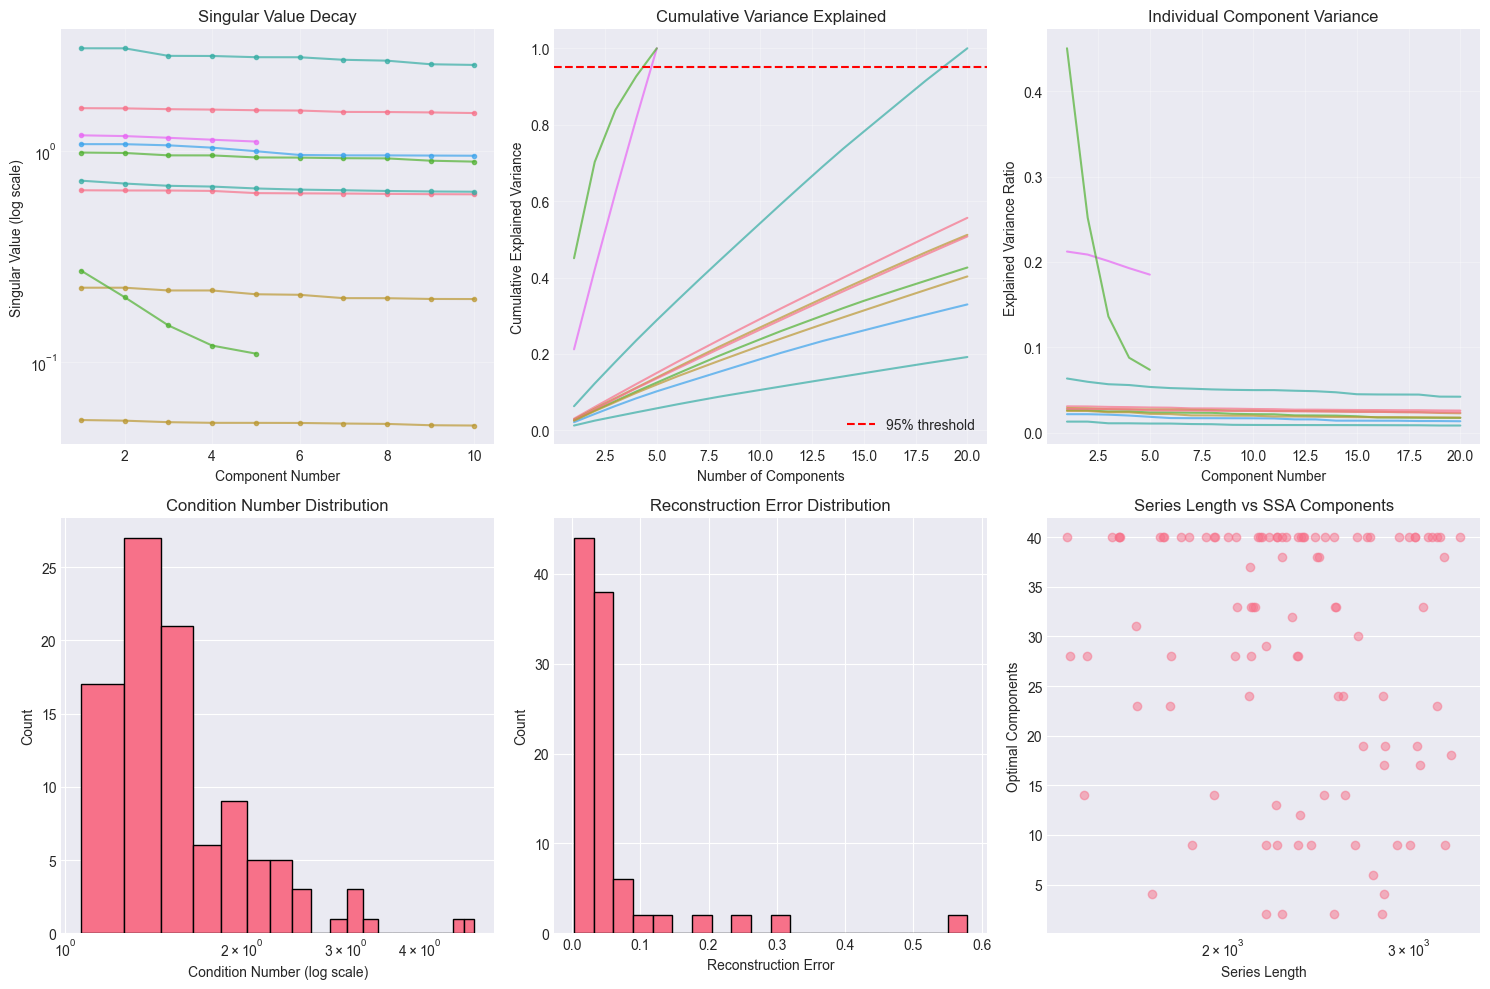

In [52]:
# Analyze singular value decay patterns
print("\n=== SINGULAR VALUE ANALYSIS ===")

# Sample some series to show singular value decay
sample_indices = np.random.choice(len(analysis_metadata), size=min(10, len(analysis_metadata)), replace=False)

plt.figure(figsize=(15, 10))

# Plot singular values
plt.subplot(2, 3, 1)
for idx in sample_indices:
    meta = analysis_metadata[idx]
    if meta['singular_values'] is not None:
        s_vals = meta['singular_values']
        plt.semilogy(range(1, len(s_vals) + 1), s_vals, alpha=0.7, marker='o', markersize=3)

plt.xlabel('Component Number')
plt.ylabel('Singular Value (log scale)')
plt.title('Singular Value Decay')
plt.grid(True, alpha=0.3)

# Plot cumulative variance
plt.subplot(2, 3, 2)
for idx in sample_indices:
    meta = analysis_metadata[idx]
    if meta['cumulative_variance'] is not None:
        plt.plot(range(1, len(meta['cumulative_variance']) + 1),
                 meta['cumulative_variance'], alpha=0.7)

plt.axhline(0.95, color='red', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot individual explained variance
plt.subplot(2, 3, 3)
for idx in sample_indices:
    meta = analysis_metadata[idx]
    if meta['explained_variance_ratio'] is not None:
        plt.plot(range(1, len(meta['explained_variance_ratio']) + 1),
                 meta['explained_variance_ratio'], alpha=0.7)

plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Component Variance')
plt.grid(True, alpha=0.3)

# Distribution plots
plt.subplot(2, 3, 4)
ssa_df['condition_number'].hist(bins=20, edgecolor='black')
plt.xlabel('Condition Number (log scale)')
plt.ylabel('Count')
plt.title('Condition Number Distribution')
plt.xscale('log')

plt.subplot(2, 3, 5)
ssa_df['reconstruction_error'].hist(bins=20, edgecolor='black')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Reconstruction Error Distribution')

plt.subplot(2, 3, 6)
# Scatter plot of series length vs optimal components
plt.scatter(ssa_df['series_length'], ssa_df['optimal_components'], alpha=0.5)
plt.xlabel('Series Length')
plt.ylabel('Optimal Components')
plt.title('Series Length vs SSA Components')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [20]:
# Summary statistics
print("\n=== SEQUENCE LENGTH ANALYSIS SUMMARY ===")
print(f"Total series analyzed: {len(seq_length_df)}")
print(f"\nOptimal sequence length statistics:")
print(seq_length_df['optimal_length'].describe())

print("\n=== SSA COMPONENT ANALYSIS SUMMARY ===")
print(f"Total series analyzed: {len(ssa_df)}")
print(f"\nOptimal SSA components statistics:")
print(ssa_df['optimal_components'].describe())
print(f"\nOptimal window length statistics:")
print(ssa_df['optimal_window_length'].describe())
print(f"\nCompression ratio statistics:")
print(ssa_df['compression_ratio'].describe())
print(f"\nReconstruction error statistics:")
print(ssa_df['reconstruction_error'].describe())

# Compare by structural break presence
if len(train_ssa) > 0:
    print("\n=== COMPARISON BY STRUCTURAL BREAK ===")
    grouped = train_ssa.groupby('has_break')

    print("\nOptimal SSA components by break:")
    print(grouped['optimal_components'].agg(['mean', 'std', 'median']))

    print("\nOptimal window length by break:")
    print(grouped['optimal_window_length'].agg(['mean', 'std', 'median']))

    print("\nCompression ratio by break:")
    print(grouped['compression_ratio'].agg(['mean', 'std', 'median']))

    print("\nReconstruction error by break:")
    print(grouped['reconstruction_error'].agg(['mean', 'std', 'median']))


=== SEQUENCE LENGTH ANALYSIS SUMMARY ===
Total series analyzed: 100

Optimal sequence length statistics:
count    100.0
mean      64.0
std        0.0
min       64.0
25%       64.0
50%       64.0
75%       64.0
max       64.0
Name: optimal_length, dtype: float64

=== SSA COMPONENT ANALYSIS SUMMARY ===
Total series analyzed: 100

Optimal SSA components statistics:
count    100.000000
mean      12.240000
std        6.561473
min        2.000000
25%        5.000000
50%       14.000000
75%       18.000000
max       20.000000
Name: optimal_components, dtype: float64

Optimal window length statistics:
count    100.000000
mean      26.460000
std       14.444194
min        5.000000
25%       11.000000
50%       29.000000
75%       37.000000
max       49.000000
Name: optimal_window_length, dtype: float64

Compression ratio statistics:
count    100.000000
mean       2.194078
std        0.155473
min        2.050000
25%        2.062500
50%        2.111111
75%        2.333333
max        2.500000
Nam

In [28]:
# Create recommendations
print("\n=== RECOMMENDATIONS ===")

# Sequence length recommendation
seq_median = seq_length_df['optimal_length'].median()
seq_mode = seq_length_df['optimal_length'].mode()[0]

print(f"\n1. Sequence Length:")
print(f"   - Most common: {seq_mode}")
print(f"   - Median: {seq_median}")
print(f"   - Recommended default: {int(2 ** round(np.log2(seq_median)))}")

# SSA components recommendation
ssa_median = ssa_df['optimal_components'].median()
ssa_mode = ssa_df['optimal_components'].mode()[0]
ssa_mean = ssa_df['optimal_components'].mean()

print(f"\n2. SSA Components (Bottleneck Dimension):")
print(f"   - Most common: {ssa_mode}")
print(f"   - Median: {ssa_median}")
print(f"   - Mean: {ssa_mean:.1f}")
print(f"   - Recommended default: {int(ssa_median)}")
print(f"   - Range for 90% of data: {ssa_df['optimal_components'].quantile(0.05):.0f} - "
      f"{ssa_df['optimal_components'].quantile(0.95):.0f}")

# Window length recommendation
window_median = ssa_df['optimal_window_length'].median()
print(f"\n3. SSA Window Length:")
print(f"   - Median: {window_median}")
print(f"   - Recommended default: {int(window_median)}")

print(f"\n4. Compression Performance:")
print(f"   - Mean compression ratio: {ssa_df['compression_ratio'].mean():.1f}:1")
print(f"   - Mean reconstruction error: {ssa_df['reconstruction_error'].mean():.3f}")
print(f"   - This suggests SSA-based autoencoders can achieve good compression with low error")


=== RECOMMENDATIONS ===

1. Sequence Length:
   - Most common: 16
   - Median: 16.0
   - Recommended default: 16

2. SSA Components (Bottleneck Dimension):
   - Most common: 20
   - Median: 11.0
   - Mean: 11.1
   - Recommended default: 11
   - Range for 90% of data: 2 - 20

3. SSA Window Length:
   - Median: 23.0
   - Recommended default: 23

4. Compression Performance:
   - Mean compression ratio: 2.2:1
   - Mean reconstruction error: 0.105
   - This suggests SSA-based autoencoders can achieve good compression with low error


In [29]:
# Save results
results_dict = {
    'sequence_length_analysis': seq_length_df,
    'ssa_analysis': ssa_df,
    'detailed_metadata': analysis_metadata,
    'recommendations': {
        'sequence_length': int(2 ** round(np.log2(seq_median))),
        'ssa_components': int(ssa_median),
        'ssa_window_length': int(window_median),
        'compression_ratio': ssa_df['compression_ratio'].mean(),
        'reconstruction_error': ssa_df['reconstruction_error'].mean()
    }
}

print("\n=== Analysis Complete ===")
print(f"Key findings:")
print(f"- SSA provides much clearer component selection than PCA")
print(f"- Median bottleneck size: {int(ssa_median)} components")
print(f"- Typical compression ratio: {ssa_df['compression_ratio'].mean():.1f}:1")
print(f"- Low reconstruction error: {ssa_df['reconstruction_error'].mean():.3f}")
print(f"- Results suggest SSA is well-suited for time series autoencoder design")


=== Analysis Complete ===
Key findings:
- SSA provides much clearer component selection than PCA
- Median bottleneck size: 11 components
- Typical compression ratio: 2.2:1
- Low reconstruction error: 0.105
- Results suggest SSA is well-suited for time series autoencoder design
